In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import glob as gb
import cv2
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
train = '../input/intel-image-classification/seg_train/seg_train'
test  = '../input/intel-image-classification/seg_test/seg_test'
pred  = '../input/intel-image-classification/seg_pred/seg_pred'

In [5]:
size  = 128
batch = 128
epochs = 40

In [6]:
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             width_shift_range=.2, height_shift_range=.2,
                             rotation_range=30,
                             brightness_range=[0.8, 1.2],
                             horizontal_flip=True)

In [7]:
X_train = datagen.flow_from_directory(directory=train, target_size=(size,size), batch_size=batch, shuffle=True,)

Found 14034 images belonging to 6 classes.


In [8]:
X_test = ImageDataGenerator(rescale=1/255).flow_from_directory(directory=test, target_size=(size,size), batch_size=batch, shuffle=True,)

Found 3000 images belonging to 6 classes.


In [9]:
X_test.class_indices.keys()

dict_keys(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

In [10]:
files = gb.glob(pathname= str(pred + '/*.jpg'))
print(f'For Prediction data, found {len(files)}')

For Prediction data, found 7301


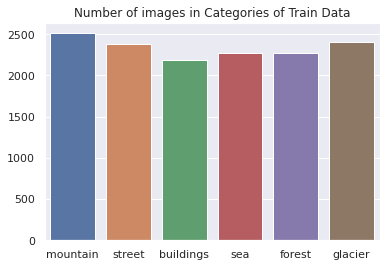

In [11]:
train_data_size = {}

for folder in  os.listdir(train) : 
    files = gb.glob(pathname= str(train +'/' + folder + '/*.jpg'))
    train_data_size[folder] = len(files)

classes = list(train_data_size.keys())
train_no_imgs = [train_data_size[i] for i in classes]

sns.barplot(classes, train_no_imgs)
plt.title("Number of images in Categories of Train Data")
plt.show()


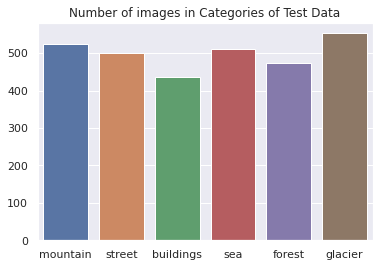

In [12]:
test_data_size = {}

for folder in  os.listdir(test) : 
    files = gb.glob(pathname= str(test +'/' + folder + '/*.jpg'))
    test_data_size[folder] = len(files)

test_no_imgs = [test_data_size[i] for i in classes]

sns.barplot(classes, test_no_imgs)
plt.title("Number of images in Categories of Test Data")
plt.show()

In [13]:
checkpoint_filepath = 'best_model.hdf5'
best_model = 'BestModel.hdf5'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.003, patience=30)
callback_learningrate = ReduceLROnPlateau(monitor='val_accuracy', mode='max', min_delta=0.003, patience=10, factor=0.5, min_lr=0.00001)

callbacks = [callback_checkpoint, callback_earlystopping, callback_learningrate]

In [14]:
Model =tf.keras.models.Sequential([ tf.keras.layers.Conv2D(256,kernel_size=(3,3),activation='relu',input_shape=(size,size,3)),
                                    tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(4,4),

                                    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),    
                                    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(3,3),

                                    tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding = 'Same'),
                                    tf.keras.layers.Conv2D(8,kernel_size=(3,3),activation='relu', padding = 'Same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2,2),

                                    tf.keras.layers.Flatten() ,
                                    tf.keras.layers.Dense(256,activation='relu'),
                                    tf.keras.layers.Dropout(rate=0.4), 
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dropout(rate=0.3),
                                    tf.keras.layers.Dense(64,activation='relu'),
                                    tf.keras.layers.Dropout(rate=0.2),
                                    tf.keras.layers.Dense(32,activation='relu') ,
                                    tf.keras.layers.Dropout(rate=0.1),            
                                    tf.keras.layers.Dense(16,activation='relu') ,
                                    tf.keras.layers.Dropout(rate=0.05),
                                    tf.keras.layers.Dense(8,activation='relu') ,
                                    tf.keras.layers.Dropout(rate=0.02),
                                    tf.keras.layers.Dense(6,activation='softmax')])


Model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(Model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 256)     7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 128)     295040    
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 32)        1

In [15]:
history = Model.fit(x=X_train, validation_data=X_test, epochs=epochs, verbose=2, callbacks=callbacks)

Epoch 1/40
110/110 - 160s - loss: 1.7570 - accuracy: 0.2121 - val_loss: 1.7087 - val_accuracy: 0.3467
Epoch 2/40
110/110 - 83s - loss: 1.4418 - accuracy: 0.4114 - val_loss: 1.4492 - val_accuracy: 0.4277
Epoch 3/40
110/110 - 82s - loss: 1.2325 - accuracy: 0.4954 - val_loss: 1.3446 - val_accuracy: 0.4557
Epoch 4/40
110/110 - 83s - loss: 1.1305 - accuracy: 0.5325 - val_loss: 1.0246 - val_accuracy: 0.5737
Epoch 5/40
110/110 - 82s - loss: 1.0556 - accuracy: 0.5664 - val_loss: 0.9661 - val_accuracy: 0.6003
Epoch 6/40
110/110 - 88s - loss: 1.0061 - accuracy: 0.5856 - val_loss: 1.2348 - val_accuracy: 0.4863
Epoch 7/40
110/110 - 86s - loss: 0.9660 - accuracy: 0.6104 - val_loss: 1.0872 - val_accuracy: 0.5377
Epoch 8/40
110/110 - 84s - loss: 0.9224 - accuracy: 0.6434 - val_loss: 0.9294 - val_accuracy: 0.6340
Epoch 9/40
110/110 - 85s - loss: 0.8876 - accuracy: 0.6692 - val_loss: 0.9330 - val_accuracy: 0.6343
Epoch 10/40
110/110 - 84s - loss: 0.8329 - accuracy: 0.7074 - val_loss: 0.8081 - val_accur

In [16]:
import tensorflow as tf
Best_Model = tf.keras.models.load_model('best_model.hdf5')

In [17]:
print("Old Classes:", classes)
classes = list(X_train.class_indices.keys())
print("New Classes:", classes)

Old Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
New Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


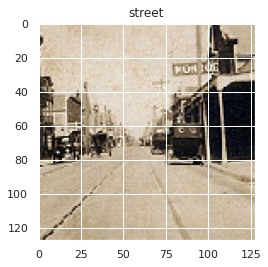

In [18]:
file = pred + "/14.jpg"
image = tf.keras.preprocessing.image.load_img(path=file, target_size=(size, size))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
y_pred = Model.predict(input_arr)
label = classes[np.argmax(y_pred)]

plt.imshow(image)
plt.title(label)
plt.show()


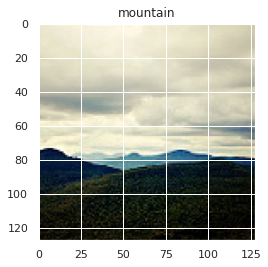

In [25]:
file = pred + "/10100.jpg"
image = tf.keras.preprocessing.image.load_img(path=file, target_size=(size, size))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
y_pred = Model.predict(input_arr)
label = classes[np.argmax(y_pred)]

plt.imshow(image)
plt.title(label)
plt.show()


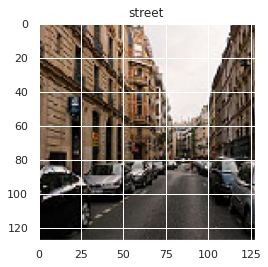

In [27]:
file = pred + "/10079.jpg"
image = tf.keras.preprocessing.image.load_img(path=file, target_size=(size, size))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
y_pred = Model.predict(input_arr)
label = classes[np.argmax(y_pred)]

plt.imshow(image)
plt.title(label)
plt.show()